### Additive Decomposing

**Outline**

* Our aim is to switch from base ESN to Deep ESN models.
* But first play with **additive decomposition** of timeseries into linear trend, seasonality and residual noise, as in [Kim and King, 2020](https://link.springer.com/article/10.1007/s00521-020-04948-x) paper "Time series prediction using Deep Echo State Networks".

**Sources**

* Index values for S&P500 is freely availably on [Yahoo finance](https://de.finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC). Used absolute closing values from August 14, 1999, to July 01, 2019 (5000 samples).
* Took *Airline Passengers* from [Tutorial](https://machinelearningmastery.com/time-series-data-stationary-python/) on "How to Check if Time Series Data is Stationary with Python".

#### Technical setup and data preparation

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pandas import read_csv

In [4]:
# Read dataset SP500_1999_2019.txt, absolute values:
SP500_abs = open("../data/SP500_1999_2019.csv").read().split()
SP500_abs = np.array(SP500_abs).astype('float64')

In [30]:
AirPass = read_csv('../data/airline-passengers.csv', header=0, index_col=0).values[:,0]

#### Additive Decomposition of timeseries

Given an input series $y$, where $y_t$ denotes the value of $y$ at time $t$. Now decompose $y_t$ into three parts $y_t = L_t + S_t + R_t$ with trend $L$, seasonality (or: periodicity) $S$ and residual noise $R$ as follows:

$$L_t = \alpha * (y_t - S_{t-s}) + (1 - \alpha) * L_{t-1}$$
$$S_t = \gamma * (y_t - L_t) + (1 - \gamma) * S_{t-s}$$
$$R_t = y_t - L_t - S_t$$

with smoothing parameters $0<\alpha<1$, $0<\gamma<1$ and hyperparameter $s$, which is the length of the season (or cycle).


In [11]:
## Define function "AD_decompose" for additive decomposing a time series into trend, seasonality and residual noise.
# Additional input parameters: smoothing parameters alpha and gamma plus length of season s.
# scaled_YN (True/False):if True, scale input_series to [0,1] applying min/max scaling before decomposing.
def AD_decompose(input_series, alpha, gamma, s, scaled_YN=False):
    
    # Get length T of input series:
    T = len(input_series)
    
    # Initialize arrays for storing trend L, seasonality S and residual noise R:
    L = np.zeros(T)
    S = np.zeros(T)
    R = np.zeros(T)
    
    # Optionally scale input series to [0,1] with min/max scaling.
    # Initialize input_min and _max to zero, to have return values even if no scaling is desired.
    input_min = 0
    input_max = 0
    if scaled_YN:
        input_min = np.min(input_series)
        input_max = np.max(input_series)

        # substract min and divide by (max - min)
        input_series = (input_series - input_min) / (input_max - input_min)
    
    # First step (t=0) needs special treatment, since we don't have L(t-1):
    L[0] = input_series[0]
    S[0] = 0
    R[0] = 0
    
    # Loop over input series and calculate trend, seasonality and residual noise.
    # Note: Start at 1, since step (t=0) is already taken care of.
    for t in range(1, T):
        
        # First s timesteps need special treatment, since we don't have S(t-s) for these steps:
        if t < s:
            L[t] = alpha * input_series[t] + (1 - alpha) * L[t-1]
            S[t] = gamma * (input_series[t] - L[t])
            R[t] = input_series[t] - L[t] - S[t]
        else:
            L[t] = alpha * (input_series[t] - S[t-s]) + (1 - alpha) * L[t-1]
            S[t] = gamma * (input_series[t] - L[t]) + (1 - gamma) * S[t-s]
            R[t] = input_series[t] - L[t] - S[t]
    
    # Return original input_series plus decomposition: Trend L, seasonality S and residual noise R.
    return input_series, L, S, R, input_min, input_max

In [15]:
# Decompose SP500 absolute values:
SP500_abs, SP500_L, SP500_S, SP500_R, SP500_min, SP500_max = AD_decompose(SP500_abs,
                                                                          alpha=0.01,
                                                                          gamma=0.01,
                                                                          s=125,
                                                                          scaled_YN=True)

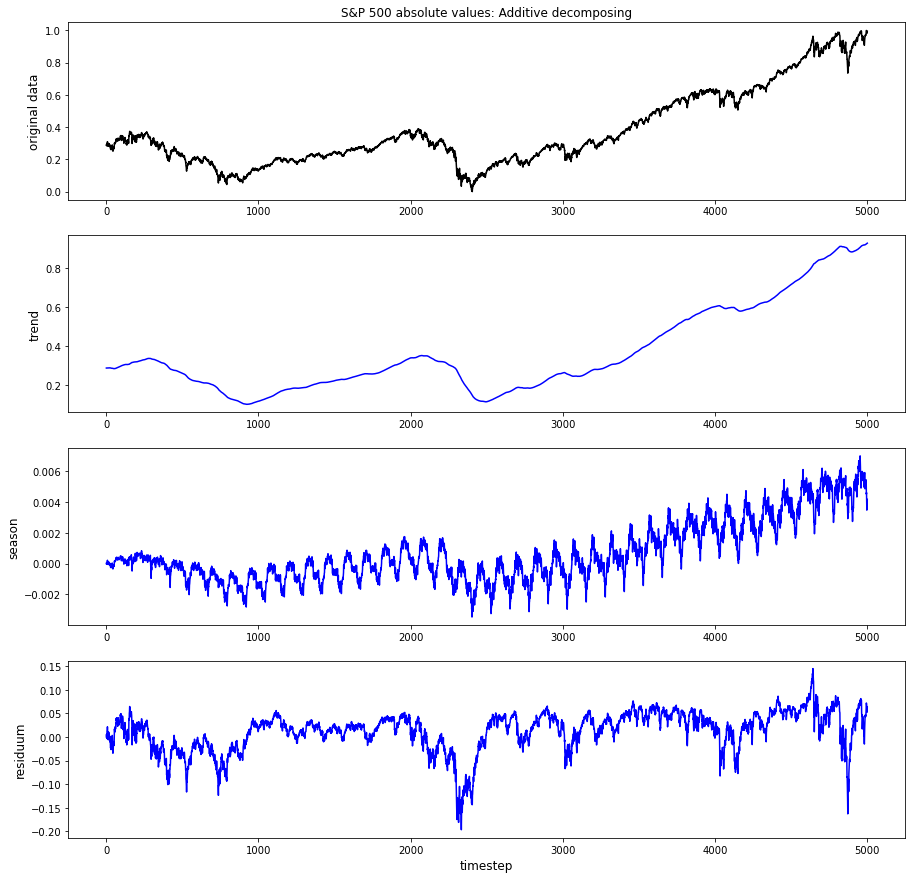

In [13]:
## Plot original SP500 timeseries, together with decomposed parts: Trend L, seasonality S and residual noise R:

# Get length T of input series:
T = len(SP500_abs)

# Plot:
fig, axes = plt.subplots(4, 1, figsize=(15,15))
axes[0].plot(range(1, T+1), SP500_abs, color="k", label="original data")
axes[1].plot(range(1, T+1), SP500_L, color="b", label="Trend")
axes[2].plot(range(1, T+1), SP500_S, color="b", label="Seasonality")
axes[3].plot(range(1, T+1), SP500_R, color="b", label="Residuum")
axes[3].set_xlabel("timestep", fontsize=12)
axes[0].set_ylabel("original data", fontsize=12)
axes[1].set_ylabel("trend", fontsize=12)
axes[2].set_ylabel("season", fontsize=12)
axes[3].set_ylabel("residuum", fontsize=12)
axes[0].set_title("S&P 500 absolute values: Additive decomposing")
plt.show()

#### The Augmented Dickey-Fuller test (ADFT)

ADFT is a type of statistical test called a unit root test. Find some more [details and examples here](https://machinelearningmastery.com/time-series-data-stationary-python/):

"(...)The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

**Null Hypothesis (H0)**: If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

**Alternate Hypothesis (H1)**: The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

**p-value > 0.05**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

**p-value <= 0.05**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
Below is an example of calculating the Augmented Dickey-Fuller test on the Daily Female Births dataset. The statsmodels library provides the **adfuller() function** that implements the test. (...)"

In [22]:
# Now apply ADFT to raw input series and results from decomposition: Trend, seasonality and residuum.
ADFT_SP500_abs = adfuller(SP500_abs)
ADFT_SP500_L = adfuller(SP500_L)
ADFT_SP500_S = adfuller(SP500_S)
ADFT_SP500_R = adfuller(SP500_R)

# Print results from ADFT:
print('\nSP500_abs:')
print('==========')
print('ADF Statistic: %f' % ADFT_SP500_abs[0])
print('p-value: %f' % ADFT_SP500_abs[1])
print('Critical Values:')
for key, value in ADFT_SP500_abs[4].items():
    print('\t%s: %.3f' % (key, value))
    
print('\nSP500_L:')
print('==========')
print('ADF Statistic: %f' % ADFT_SP500_L[0])
print('p-value: %f' % ADFT_SP500_L[1])
print('Critical Values:')
for key, value in ADFT_SP500_L[4].items():
    print('\t%s: %.3f' % (key, value))
    
print('\nSP500_S:')
print('==========')
print('ADF Statistic: %f' % ADFT_SP500_S[0])
print('p-value: %f' % ADFT_SP500_S[1])
print('Critical Values:')
for key, value in ADFT_SP500_S[4].items():
    print('\t%s: %.3f' % (key, value))
    
print('\nSP500_R:')
print('==========')
print('ADF Statistic: %f' % ADFT_SP500_R[0])
print('p-value: %f' % ADFT_SP500_R[1])
print('Critical Values:')
for key, value in ADFT_SP500_R[4].items():
    print('\t%s: %.3f' % (key, value))


SP500_abs:
ADF Statistic: 0.996594
p-value: 0.994230
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567

SP500_L:
ADF Statistic: 1.123145
p-value: 0.995409
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567

SP500_S:
ADF Statistic: -4.202978
p-value: 0.000651
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567

SP500_R:
ADF Statistic: -4.748862
p-value: 0.000068
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


#### Discussion of results on S&P 500 data

Here we took absolute index values as input series for decomposition. However, it is not obvious how to set smoothing parameters $\alpha$ and $\gamma$ and [Kim and King, 2020](https://link.springer.com/article/10.1007/s00521-020-04948-x) do not reveal the necessary details in their paper. Setting $\alpha=0.01$ and $\gamma=0.01$, resulting trend and seasonality at least comes close to results shown in the paper. Also choosing the period $s=125$ is not straight-forward, but [Kim and King, 2020](https://link.springer.com/article/10.1007/s00521-020-04948-x) seem to work with similar $s$.

We then scaled input data before decomposing. Note: We cannot expect any *clear* trend in stock price data, since in reality stock price movements are rather random.

Looking at results from ADFT, the trend "L" shows $p$-value close to one, telling us, that we still have a highly non-stationary data. But seasonality $S$ and residual noise $R$ come with $p$-values close to zero, hence decomposing has some benefit: Instead of feeding only the highly non-stationary raw series, we can now use raw data plus decomposed components as input for a Deep ESN, where at least $S$ and $R$ appear to be stationary.

In [55]:
# Decompose Airline Passengers:
AirPass_abs, AirPass_L, AirPass_S, AirPass_R, AirPass_min, AirPass_max = AD_decompose(AirPass,
                                                                          alpha=0.1,
                                                                          gamma=0.1,
                                                                          s=12,
                                                                          scaled_YN=True)

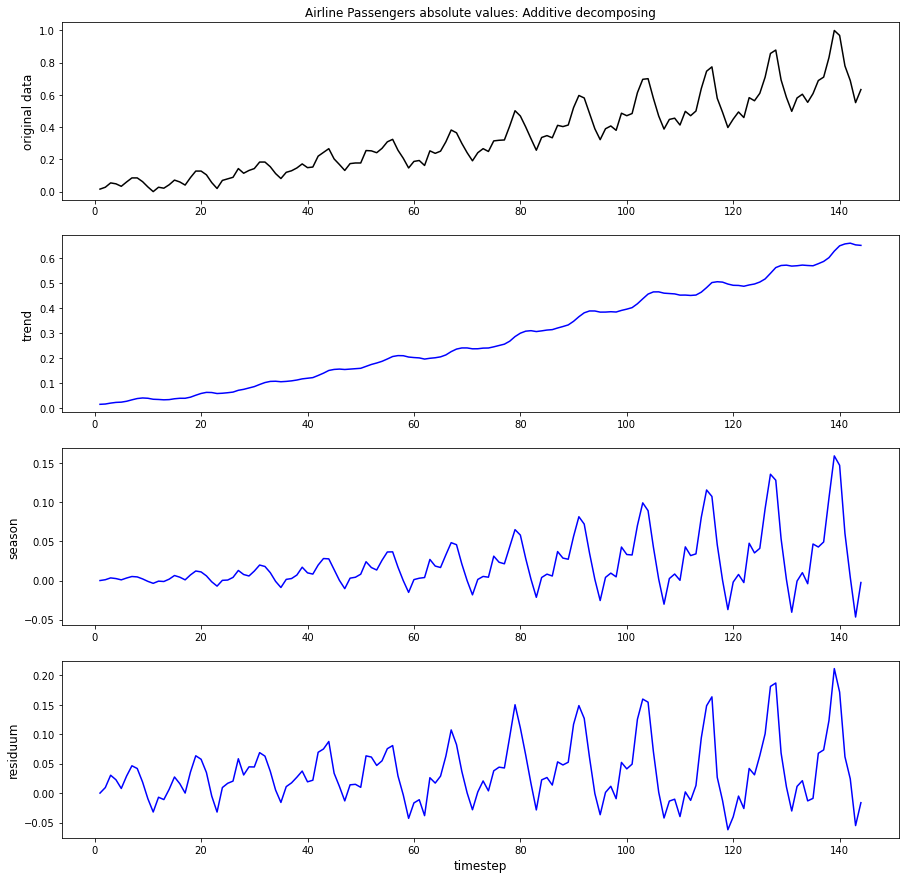

In [56]:
## Plot original AirPass timeseries, together with decomposed parts: Trend L, seasonality S and residual noise R:

# Get length T of input series:
T = len(AirPass_abs)

# Plot:
fig, axes = plt.subplots(4, 1, figsize=(15,15))
axes[0].plot(range(1, T+1), AirPass_abs, color="k", label="original data")
axes[1].plot(range(1, T+1), AirPass_L, color="b", label="Trend")
axes[2].plot(range(1, T+1), AirPass_S, color="b", label="Seasonality")
axes[3].plot(range(1, T+1), AirPass_R, color="b", label="Residuum")
axes[3].set_xlabel("timestep", fontsize=12)
axes[0].set_ylabel("original data", fontsize=12)
axes[1].set_ylabel("trend", fontsize=12)
axes[2].set_ylabel("season", fontsize=12)
axes[3].set_ylabel("residuum", fontsize=12)
axes[0].set_title("Airline Passengers absolute values: Additive decomposing")
plt.show()

In [57]:
# No apply ADFT to raw input series and results from decomposition: Trend, seasonality and residuum.
ADFT_AirPass_abs = adfuller(AirPass_abs)
ADFT_AirPass_L = adfuller(AirPass_L)
ADFT_AirPass_S = adfuller(AirPass_S)
ADFT_AirPass_R = adfuller(AirPass_R)

# Print results from ADFT:
print('\nAirPass_abs:')
print('==========')
print('ADF Statistic: %f' % ADFT_AirPass_abs[0])
print('p-value: %f' % ADFT_AirPass_abs[1])
    
print('\nAirPass_L:')
print('==========')
print('ADF Statistic: %f' % ADFT_AirPass_L[0])
print('p-value: %f' % ADFT_AirPass_L[1])
    
print('\nAirPass_S:')
print('==========')
print('ADF Statistic: %f' % ADFT_AirPass_S[0])
print('p-value: %f' % ADFT_AirPass_S[1])
    
print('\nAirPass_R:')
print('==========')
print('ADF Statistic: %f' % ADFT_AirPass_R[0])
print('p-value: %f' % ADFT_AirPass_R[1])

print('Critical Values:')
for key, value in ADFT_AirPass_R[4].items():
    print('\t%s: %.3f' % (key, value))


AirPass_abs:
ADF Statistic: 0.815369
p-value: 0.991880

AirPass_L:
ADF Statistic: 1.629968
p-value: 0.997945

AirPass_S:
ADF Statistic: 2.009104
p-value: 0.998685

AirPass_R:
ADF Statistic: -2.519561
p-value: 0.110787
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


#### Discussion of results on S&P 500 data

Here we took absolute airline passengers as input series for decomposition. Again, it is not obvious how to set smoothing parameters $\alpha$ and $\gamma$. 

Opposed to stock index values, we find a clear seasonality cycle with length $s=12$ (months). 

But we failed to choose appropriate smoothing parameters. Data shows some increasing amplitude over time. Hence some form of multiplicative decomposing should be applied or some log-scaling.